In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays # 可选，用于处理稀疏性（如果数据量很大）
using FileIO
using JLD2
using Plots
using LaTeXStrings

using DataFrames, Colors
using StatsPlots   # 提供 boxplot，基于 Plots

include("Data_Generation_PLD.jl")
include("Estimation_PLD.jl")
include("Models_PLD.jl")
include("Evaluation_PLD.jl")

calculate_profit (generic function with 1 method)

In [2]:
N = 2 # num of product
N_x = 20 # num of product feature
c_l = ones(N_x)  # X * c_l >= d_r
d_r = ones(N) * 5
rev_gap = 0.001
N_u = 5 # num of customer feature
S_train = 200 # num of training samples
S_test = 1 # num of training samples
m = 5 # num of candidates in training samples
N_nonzero = 5 # num of nonzero entries in A
lambda_list = [0.0]
gamma_list = [0.0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5]
gamma_list = [0.0]

instances = 10
Random.seed!(2)
project_dir = "N=$(N)_N_x=$(N_x)_N_u=$(N_u)_S_train=$(S_train)_N_nonzero=$(N_nonzero)/"

"N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/"

In [3]:
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/Product_Line_Design/")
if !isdir(data_dir)
    mkpath(data_dir)
end
data_dir = string(data_dir,project_dir)
println("Data directory: ", data_dir)

Data directory: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/


#### Data Generation

In [4]:
function compute_w(alpha0,alpha,beta,A,z_input)
    nu0 = alpha0 + beta' * z_input;
    nu = alpha .+ A * z_input;
    return nu0,nu
end

compute_w (generic function with 1 method)

In [ ]:
Input_Data = Dict()
ins = 1
while ins <= instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    # ****** Data ******
    theta_true, r_params = Generate_Wang_Qi_Max_True_Paras(N_x,N_u,N_nonzero);
    X_train,Y_train,Z_train = Generate_Wang_Qi_Max_True_Data(N_x, N_u, S_train, m,theta_true);
    X_test,Y_test,Z_test = Generate_Wang_Qi_Max_True_Data(N_x, N_u, S_test, m,theta_true);
    z_input = Z_test[1,:];
    nu0_true,nu_true = compute_w(theta_true.alpha0,theta_true.alpha,theta_true.beta,theta_true.A,z_input)
    w_true = [nu0_true;nu_true]

    is_extreme_estimation = false
    Estimate_Dict = Dict()
    for lambda in lambda_list
        alpha0_hat, alpha_hat, beta_hat, A_hat, opt_result = estimate_parameters(X_train,Y_train,Z_train,lambda, N_x, N_u, initial_theta=randn((N_x+1)*(N_u+1)) * 0.1);
        nu0_hat,nu_hat = compute_w(alpha0_hat,alpha_hat,beta_hat,A_hat,z_input)
        w_hat = [nu0_hat;nu_hat]

        if norm(w_hat .- w_true,2) >= 20
            println("ins=$(ins)_w_hat=",round.(w_hat,digits=2))
            is_extreme_estimation = true
            break
        else
            println("ins=$(ins)_w_hat=",round.(w_hat,digits=2))
            Estimate_Dict["alpha0_lambda=$lambda"] = alpha0_hat
            Estimate_Dict["alpha_lambda=$lambda"] = alpha_hat
            Estimate_Dict["beta_lambda=$lambda"] = beta_hat
            Estimate_Dict["A_lambda=$lambda"] = A_hat
            Estimate_Dict["opt_result_lambda=$lambda"] = opt_result
            Estimate_Dict["nu0_lambda=$lambda"] = nu0_hat
            Estimate_Dict["nu_lambda=$lambda"] = nu_hat
        end
    end
    if is_extreme_estimation
        continue
    else
        Input_Data["theta_true_ins=$ins"] = theta_true
        Input_Data["r_params_ins=$ins"] = r_params
        Input_Data["X_train_ins=$ins"] = X_train
        Input_Data["Y_train_ins=$ins"] = Y_train
        Input_Data["Z_train_ins=$ins"] = Z_train
        Input_Data["X_test_ins=$ins"] = X_test
        Input_Data["Y_test_ins=$ins"] = Y_test
        Input_Data["Z_test_ins=$ins"] = Z_test
        Input_Data["Estimate_ins=$ins"] = Estimate_Dict
        Input_Data["nu0_ins=$ins"] = nu0_true
        Input_Data["nu_ins=$ins"] = nu_true
        ins = ins + 1
    end
    println(data_dir_ins)
end
save(string(data_dir,"Input_Data.jld2"),Input_Data)

ins=1_w_hat=[10.69, 1.76, -3.05, -0.59, -0.5, -0.07, -0.87, 0.41, -0.78, -0.74, -0.28, -1.42, 0.35, -0.61, -1.4, 1.37, -2.88, 0.46, 2.37, 0.66, -3.36]
ins=1_w_hat=[-1.89, 1.83, -0.49, 1.36, 0.03, -0.08, -1.98, -0.12, 0.37, 2.47, -0.63, 0.82, 2.94, -0.27, -1.58, 1.02, 1.56, -2.35, -0.47, -0.67, 0.91]
/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=1/
ins=2_w_hat=[5.05, -0.7, -1.89, -1.3, 3.06, 0.16, -0.45, -1.18, 3.32, 2.61, -0.65, -4.27, 1.13, 2.26, -0.93, -4.75, 0.06, 1.02, 1.13, -3.12, 1.12]
/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=2/
ins=3_w_hat=[0.2, 0.7, 0.39, 0.29, -0.69, -0.73, -1.08, -1.74, -0.45, 1.06, -1.23, -0.88, 0.05, 0.19, -1.25, 0.41, 0.38, -0.58, -0.19, -0.05, -1.09]
/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=3/
ins=4_w_hat=[-1.12, -0.04, -0.53, -0.

#### True

In [6]:
function get_input_data_ins(Input_Data,ins)
    theta_true = Input_Data["theta_true_ins=$ins"]
    r_params = Input_Data["r_params_ins=$ins"]
    X_train = Input_Data["X_train_ins=$ins"]
    Y_train = Input_Data["Y_train_ins=$ins"]
    Z_train = Input_Data["Z_train_ins=$ins"]
    X_test = Input_Data["X_test_ins=$ins"]
    Y_test = Input_Data["Y_test_ins=$ins"]
    Z_test = Input_Data["Z_test_ins=$ins"]
    r0 = r_params.r0;
    r = r_params.r;
    alp0_true = theta_true.alpha0;
    alp_true = theta_true.alpha;
    beta_true = theta_true.beta;
    A_true = theta_true.A;
    return r0,r,alp0_true,alp_true,beta_true,A_true,Z_test
end

get_input_data_ins (generic function with 1 method)

In [23]:
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    r0,r,alp0_true,alp_true,beta_true,A_true,Z_test = get_input_data_ins(Input_Data,ins)
    nu0_true = Input_Data["nu0_ins=$ins"]
    nu_true = Input_Data["nu_ins=$ins"]
    w_true = [nu0_true;nu_true]

    Estimate_Dict = Input_Data["Estimate_ins=$ins"]
    l_index = 1
    lambda = lambda_list[l_index]

    nu0 = Estimate_Dict["nu0_lambda=$lambda"]
    nu = Estimate_Dict["nu_lambda=$lambda"]
    w_hat = [nu0;nu]
    println("diff=",round.(w_true .- w_hat,digits=2))
    println("norm = ",norm(w_hat .- w_true,2))

end

diff=[1.69, -1.33, -0.49, -1.15, 0.55, 0.07, 1.25, 0.23, -1.07, -1.57, -0.37, -0.57, -1.68, -0.41, 0.61, -0.22, -0.6, 2.39, 1.0, 0.15, -1.45]
norm = 4.9785968079343235
diff=[-2.74, -0.55, 0.91, 0.62, -1.89, 0.2, 0.4, 1.34, -1.89, -2.09, 0.65, 3.19, -1.26, -1.3, 0.04, 3.95, -0.32, -0.34, -0.35, 2.9, -0.59]
norm = 7.821512227864024
diff=[-0.53, 0.29, -0.59, 0.16, -0.03, -0.09, 0.68, 1.07, -0.51, 0.11, 0.65, 0.04, 0.46, 0.2, 0.32, -0.84, -0.06, -0.69, 0.6, 0.08, 0.37]
norm = 2.255111600046209
diff=[1.87, -0.34, 0.69, 0.09, 0.64, 0.18, -0.11, -0.3, -0.05, 1.71, -1.25, 0.06, -0.55, -1.31, 0.3, 0.36, -0.45, -1.2, 0.43, 0.51, -0.54]
norm = 3.7084053294576673
diff=[-0.67, 0.61, 0.14, 0.8, -0.3, 0.04, 0.46, 1.53, -2.12, 1.08, 0.37, -1.96, 0.7, -0.26, 0.64, 0.07, -2.69, -0.23, 2.11, -1.04, 2.01]
norm = 5.618365832688122
diff=[-3.41, 1.2, -0.79, 2.04, -0.33, -0.75, 1.08, -0.57, 0.72, 1.29, 3.2, -0.88, -0.79, 1.14, 0.92, 0.73, -0.74, 0.95, 1.18, 0.53, 0.42]
norm = 6.31226391283854
diff=[-1.99, 0.8

In [24]:
num_c = 4

4

In [25]:
Result_True_Dict = Dict();
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    r0,r,alp0_true,alp_true,beta_true,A_true,Z_test = get_input_data_ins(Input_Data,ins)
    nu0 = Input_Data["nu0_ins=$ins"]
    nu = Input_Data["nu_ins=$ins"]

    obj_True_list = zeros(S_test);
    x_True_list = zeros(S_test,N,N_x);
    time_True_list = zeros(S_test);
    profit_True_list = zeros(S_test);
    for i in 1:S_test
        z_input = Z_test[i,:];
        obj_True_list[i], x_True_list[i,:,:], time_True_list[i] = ETO_PLD(N,N_x,nu0, nu, r0, r,c_l,d_r,rev_gap,num_c);
        profit_True_list[i] = calculate_profit(alp0_true, alp_true, beta_true, A_true, r0, r, x_True_list[i,:,:], z_input)
        # if i % 20 == 1
        #     println("True: i=$i, obj=$(round(obj_True_list[i], digits=4)), profit=$(round(profit_True_list[i], digits=4)), time=$(round(time_True_list[i],digits=4))")
        # end                         
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
    Result_True_Dict["obj_ins=$ins"] = obj_True_list
    Result_True_Dict["sol_ins=$ins"] = x_True_list
    Result_True_Dict["time_ins=$ins"] = time_True_list
    Result_True_Dict["profit_ins=$ins"] = profit_True_list
end
save(string(data_dir,"Result_True.jld2"),Result_True_Dict) 

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=6/*************
************ data_dir_ins: /

#### Estimate-then-optimize

In [26]:
Result_ETO_Dict = Dict();
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    r0,r,alp0_true,alp_true,beta_true,A_true,Z_test = get_input_data_ins(Input_Data,ins)
    Estimate_Dict = Input_Data["Estimate_ins=$ins"]
    lambda_len = length(lambda_list)
    for l_index in 1:lambda_len
        lambda = lambda_list[l_index]

        nu0 = Estimate_Dict["nu0_lambda=$lambda"]
        nu = Estimate_Dict["nu_lambda=$lambda"]

        obj_ETO_list = zeros(S_test);
        x_ETO_list = zeros(S_test,N,N_x);
        time_ETO_list = zeros(S_test);
        profit_ETO_list = zeros(S_test);
        for i in 1:S_test
            z_input = Z_test[i,:];
            obj_ETO_list[i], x_ETO_list[i,:,:], time_ETO_list[i] = ETO_PLD(N,N_x,nu0, nu, r0, r,c_l,d_r,rev_gap,num_c);
            profit_ETO_list[i] = calculate_profit(alp0_true, alp_true, beta_true, A_true, r0, r, x_ETO_list[i,:,:], z_input)
            # if i % 20 == 1
            #     println("ETO: lambda=$lambda,i=$i, obj=$(round(obj_ETO_list[i], digits=4)), profit=$(round(profit_ETO_list[i], digits=4)),time=$(round(time_ETO_list[i],digits=4))")
            # end
        end
        Result_ETO_Dict["obj_ins=$(ins)_lambda=$lambda"] = obj_ETO_list
        Result_ETO_Dict["sol_ins=$(ins)_lambda=$lambda"] = x_ETO_list
        Result_ETO_Dict["time_ins=$(ins)_lambda=$lambda"] = time_ETO_list
        Result_ETO_Dict["profit_ins=$(ins)_lambda=$lambda"] = profit_ETO_list
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
end
save(string(data_dir,"Result_ETO.jld2"),Result_ETO_Dict) 

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=6/*************
************ data_dir_ins: /

#### Robust

In [11]:
function calculate_phi_bounds(N_x,r0,r,c_l,d_r_this,is_lb)
    model = Model(Mosek.Optimizer)
    set_attribute(model, "QUIET", true)
    # 定义变量
    @variable(model, X[1:N_x], Bin)        # 二进制变量 x_{jk}    
    @constraint(model, X' * c_l >= d_r_this)
    if is_lb
        @objective(model, Min, r0 + r' * X)
    else
        @objective(model, Max, r0 + r' * X)
    end
    optimize!(model)
    status = JuMP.termination_status(model)
    obj_val = objective_value(model)
    X_val = round.(value.(X))
    return obj_val,X_val
end

calculate_phi_bounds (generic function with 1 method)

In [35]:
dual_norm = 2
Result_RO_Dict = Dict();
for ins in 1:instances
    data_dir_ins = string(data_dir, "instance=$ins/")
    r0,r,alp0_true,alp_true,beta_true,A_true,Z_test = get_input_data_ins(Input_Data,ins)
    Estimate_Dict = Input_Data["Estimate_ins=$ins"]
    lambda_len = length(lambda_list)
    gamma_len = length(gamma_list)
    for l_index in 1:lambda_len
        lambda = lambda_list[l_index]
        nu0 = Estimate_Dict["nu0_lambda=$lambda"]
        nu = Estimate_Dict["nu_lambda=$lambda"]

        for g_index in 1:gamma_len
            gamma = gamma_list[g_index]
            obj_RO_list = zeros(S_test);
            x_RO_list = zeros(S_test,N,N_x);
            time_RO_list = zeros(S_test);
            profit_RO_list = zeros(S_test);
            for i in 1:S_test
                z_input = Z_test[i,:];                
                r_lb,x_lb = calculate_phi_bounds(N_x,r0,r,c_l,d_r[1],true)
                r_ub,x_ub = calculate_phi_bounds(N_x,r0,r,c_l,d_r[1],false);
                phi_lb_cal = r_lb - r_ub
                psi_lb = -10 * ones(N)
                psi_ub = 0 * ones(N)
                phi_lb = -10 * ones(N)
                phi_ub = 0 * ones(N)

                obj_RO_list[i], x_RO_list[i,:,:], time_RO_list[i] = RO_PLD(N,N_x,nu0,nu,r0,r,c_l,d_r,rev_gap,psi_lb,psi_ub,phi_lb,phi_ub,gamma,dual_norm,num_c)
                profit_RO_list[i] = calculate_profit(alp0_true, alp_true, beta_true, A_true, r0, r, x_RO_list[i,:,:], z_input)
                # if i % 20 == 1
                #     println("RO: lambda=$lambda,gamma=$gamma, i=$i, obj=$(round(obj_RO_list[i], digits=4)), profit=$(round(profit_RO_list[i], digits=4)),x=$(round.(x_RO_list[i,:], digits=4)), time=$(round(time_RO_list[i],digits=4))")
                # end
            end
            Result_RO_Dict["obj_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = obj_RO_list
            Result_RO_Dict["sol_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = x_RO_list
            Result_RO_Dict["time_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = time_RO_list
            Result_RO_Dict["profit_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"] = profit_RO_list
        end
    end
    println("************ data_dir_ins: ", data_dir_ins,"*************")
end
save(string(data_dir,"Result_RO.jld2"),Result_RO_Dict) 

************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=1/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=2/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=3/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=4/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=5/*************
************ data_dir_ins: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=2_N_x=20_N_u=5_S_train=200_N_nonzero=5/instance=6/*************
************ data_dir_ins: /

#### Results

In [30]:
Result_True_Dict = load(string(data_dir,"Result_True.jld2"));
Result_ETO_Dict = load(string(data_dir,"Result_ETO.jld2"));
Result_RO_Dict = load(string(data_dir,"Result_RO.jld2"));

In [14]:
# for k in keys(Result_RO_Dict)
#     if occursin("profit_ins=99", k)
#         println(k)
#     end
# end

In [31]:
obj_True_avg = zeros(instances);
obj_ETO_avg = zeros(instances, length(lambda_list));
obj_RO_avg = zeros(instances, length(lambda_list), length(gamma_list));
for ins in 1:instances
    obj_True_avg[ins] = mean(Result_True_Dict["obj_ins=$ins"])
    for l_index in 1:length(lambda_list)
        lambda = lambda_list[l_index]
        obj_ETO_avg[ins,l_index] = mean(Result_ETO_Dict["obj_ins=$(ins)_lambda=$lambda"])
        for g_index in 1:length(gamma_list)
            gamma = gamma_list[g_index]
            obj_RO_avg[ins,l_index,g_index] = mean(Result_RO_Dict["obj_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"])
            # println("ins=$ins, lambda=$lambda, gamma=$gamma, profit_True_avg=$(round(profit_True_avg,digits=4)), profit_ETO_avg=$(round(profit_ETO_avg,digits=4)), profit_RO_avg=$(round(profit_RO_avg,digits=4))")
        end
    end
end

In [32]:
println("obj_ETO:",round.(obj_ETO_avg[:,1],digits=2))
println("obj_RO:",round.(obj_RO_avg[:,1,1],digits=2))
println("obj_ETO avg:",mean(obj_ETO_avg[:,1]))
println("obj_RO avg:",mean(obj_RO_avg[:,1,1]))

obj_ETO:[4.09, 5.29, 3.43, 4.08, 4.3, 3.92, 3.83, 3.96, 4.09, 4.56]
obj_RO:[4.04, 5.28, 3.34, 4.03, 4.29, 3.9, 3.79, 3.93, 4.02, 4.48]
obj_ETO avg:4.155660615474995
obj_RO avg:4.108884715344325


In [33]:
profit_True_avg = zeros(instances);
profit_ETO_avg = zeros(instances, length(lambda_list));
profit_RO_avg = zeros(instances, length(lambda_list), length(gamma_list));
for ins in 1:instances
    profit_True_avg[ins] = mean(Result_True_Dict["profit_ins=$ins"])
    for l_index in 1:length(lambda_list)
        lambda = lambda_list[l_index]
        profit_ETO_avg[ins,l_index] = mean(Result_ETO_Dict["profit_ins=$(ins)_lambda=$lambda"])
        for g_index in 1:length(gamma_list)
            gamma = gamma_list[g_index]
            profit_RO_avg[ins,l_index,g_index] = mean(Result_RO_Dict["profit_ins=$(ins)_lambda=$(lambda)_gamma=$gamma"])
            # println("ins=$ins, lambda=$lambda, gamma=$gamma, profit_True_avg=$(round(profit_True_avg,digits=4)), profit_ETO_avg=$(round(profit_ETO_avg,digits=4)), profit_RO_avg=$(round(profit_RO_avg,digits=4))")
        end
    end
end

In [34]:
println("profit_ETO/profit_True = ",mean(profit_ETO_avg[:,1])/mean(profit_True_avg))
println("profit_ETO:",round.(profit_ETO_avg[:,1],digits=2))
println("profit_RO:",round.(profit_RO_avg[:,1,1],digits=2))

profit_ETO/profit_True = 0.910616159779931
profit_ETO:[3.85, 5.05, 3.0, 3.96, 4.27, 1.69, 2.43, 3.95, 3.67, 4.44]
profit_RO:[3.85, 5.19, 3.0, 3.96, 4.27, 2.44, 2.43, 3.9, 3.69, 4.49]


##### Line plot 

In [19]:
l_index = 1
RO_ETO_Ratio_Mean = zeros(length(gamma_list))
RO_ETO_Ratio_Std = zeros(length(gamma_list))
for g_index in 1:length(gamma_list)
    gamma = gamma_list[g_index]
    RO_ETO_Ratio_Mean[g_index] = mean(profit_RO_avg[:,l_index,g_index])/mean(profit_ETO_avg[:,l_index])
    RO_ETO_Ratio_Std[g_index] = std(profit_RO_avg[:,l_index,g_index])/std(profit_ETO_avg[:,l_index])
    println("gamma=$gamma,Mean =",RO_ETO_Ratio_Mean[g_index],", Std =",RO_ETO_Ratio_Std[g_index])
end

gamma=0.0,Mean =1.0049351760947183, Std =0.9877336348356306


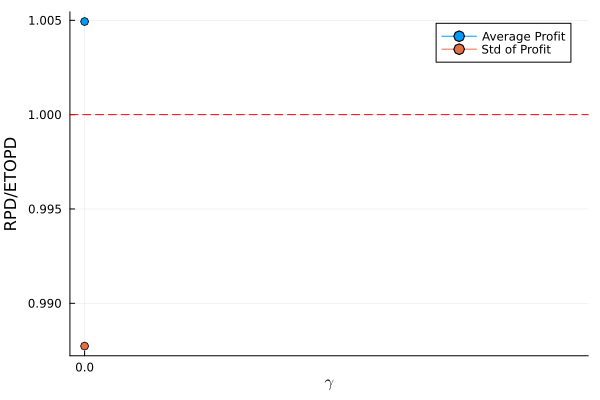

In [20]:
end_index = length(gamma_list)
plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
hline!([1.0], linestyle=:dash, color=:red, label="")
# savefig(string(data_dir, "RPD_vs_ETOPD.pdf"))

##### Boxplot

In [21]:
# Profit_ETO_All_Ins = profit_ETO_avg[:,1];
# Profit_RO_All_Ins = Dict();
# for g_index in 1:length(gamma_list)
#     gamma=gamma_list[g_index]
#     Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO_avg[:,1,g_index]
# end

In [22]:
# gamma_chosen = gamma_list[1:5]
# data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
# labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# # --- 1) 展开成长表 ---
# df = DataFrame(
#     value = vcat(data...),
#     group = repeat(labels, inner = length(data[1]))
# )

# mycolors = palette(:tab10)[1:length(labels)]   # tab10 最多10个颜色

# # --- 3) 绘制箱线图 ---
# @df df boxplot(:group, :value;
#     group = :group,
#     palette = mycolors,
#     legend = false,
#     ylabel = "Revenue",
#     # title = "Revenue Distribution"
# )

# # --- 4) 计算均值 ---
# means = combine(groupby(df, :group), :value => mean => :mean_val)

# for i in 1:length(labels)
#     scatter!([labels[i]], [means.mean_val[i]];
#         color = :red,
#         marker = (:star, 10),
#         label = "")
# end

# # # --- 6) 绘制均值连线（这里必须把类别转为数值 1:N） ---
# plot!(labels, means.mean_val;
#     seriestype = :line,
#     color = :red,
#     lw = 2,
#     ls = :dash,
#     label = "Mean trend"
# )